In [1]:
import os
import torch
import numpy as np
import idx2numpy
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
path = '/home/vidhiwar/Data/mnist'
np.random.seed(10)


In [3]:

class Tanh:
    def forward(self, x):
        return np.tanh(x)

    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - np.square(output)) * top_diff
    
class MultiplyGate:
    def forward(self,W, x):
        return np.dot(W, x)

    def backward(self, W, x, dz):
        dW = np.asarray(np.dot(np.transpose(np.asmatrix(dz)), np.asmatrix(x)))
        dx = np.dot(np.transpose(W), dz)
        return dW, dx

class AddGate:
    def forward(self, x1, x2):
        return x1 + x2

    def backward(self, x1, x2, dz):
        dx1 = dz * np.ones_like(x1)
        dx2 = dz * np.ones_like(x2)
        return dx1, dx2
    
class RNNLayer:
    def __init__(self):
        self.mulGate = MultiplyGate()
        self.addGate = AddGate()
        self.activation = Tanh()
        
        
    def forward(self, x, prev_s, U, W, V):

        self.mulu = self.mulGate.forward(U, x)
        self.mulw = self.mulGate.forward(W, prev_s)

        self.add = self.addGate.forward(self.mulw, self.mulu)
        self.s = self.activation.forward(self.add)

        self.mulv = self.mulGate.forward(V, self.s)

    def backward(self, x, prev_s, U, W, V, diff_s, dmulv):
        self.forward(x, prev_s, U, W, V)

        dV, dsv = self.mulGate.backward(V, self.s, dmulv)
        ds = dsv + diff_s
        dadd = self.activation.backward(self.add, ds)
        dmulw, dmulu = self.addGate.backward(self.mulw, self.mulu, dadd)
        dW, dprev_s = self.mulGate.backward(W, prev_s, dmulw)
        dU, dx = self.mulGate.backward(U, x, dmulu)
        return (dprev_s, dU, dW, dV)

class Softmax:
    def predict(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores)

    def loss(self, x, y):
        probs = self.predict(x)

        return -np.log(probs[y])

    def diff(self, x, y):
        probs = self.predict(x)
        probs[y] -= 1.0
        return probs
    
class RNN_numpy:
    def __init__(self, input_size, hidden_size, output_size, bptt_truncate=4):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bptt_truncate = bptt_truncate
        self.output_size = output_size
        self.U = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size),(hidden_size,input_size))
        self.W = np.random.uniform(-np.sqrt(1./input_size), np.sqrt(1./input_size),(hidden_size, hidden_size))
        self.V = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size),(output_size, hidden_size))
        
    def forward(self, x):
        time_steps = x.shape[0]
        layers = []
        h = np.zeros(self.hidden_size)
        for t in range(time_steps):
            layer = RNNLayer()
            layer.forward(x[t,:], h, self.U, self.W, self.V)
            h = layer.s
            layers.append(layer)
        return layers
    
    def predict(self, x):
        output_fn = Softmax()
        layers = self.forward(x)
        return [np.argmax(output_fn.predict(layer.mulv)) for layer in layers]
    
    def bptt(self, x, y):
        output = Softmax()
        layers = self.forward(x)
        dU = np.zeros(self.U.shape)
        dV = np.zeros(self.V.shape)
        dW = np.zeros(self.W.shape)
        
        time_steps = len(layers)
        prev_h = np.zeros(self.hidden_size)
        diff_h = np.zeros_like(prev_h)
        for t in range(time_steps):
            
            dmulv = output.diff(layers[t].mulv, y)
            inputs = x[t,:]
            dprev_s, dU_t, dW_t, dV_t = layers[t].backward(inputs, prev_h, self.U, self.W, self.V, diff_h, dmulv)
            prev_h = layers[t].s
            dmulv = np.zeros(self.output_size)
            for i in range(t-1, max(-1, t-self.bptt_truncate-1), -1):
                inputs = x[t,:]
                prev_s_i = np.zeros(self.hidden_size) if i == 0 else layers[i-1].s
                dprev_s, dU_i, dW_i, dV_i = layers[i].backward(inputs, prev_s_i, self.U, self.W, self.V, dprev_s, dmulv)
                dU_t += dU_i
                dW_t += dW_i
            dV += dV_t
            dU += dU_t
            dW += dW_t
        return (dU, dW, dV)
    
    def backward(self, x, y, lr):
        dU, dW, dV = self.bptt(x, y)
        self.U -= lr * dU
        self.V -= lr * dV
        self.W -= lr * dW

In [4]:
class RNN_torch(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE):
        super(RNN_torch, self).__init__()
        self.rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=1, batch_first=True)
        self.fc = nn.Linear(HIDDEN_SIZE,OUTPUT_SIZE)
    def forward(self,x):
        out,_ = self.rnn(x,None)
        out = self.fc(out[:,-1,:])
        return out
            

In [16]:
EPOCH = 10
BATCH_SIZE = 1
TIME_STEP = 28
INPUT_SIZE = 28
HIDDEN_SIZE = 64
OUTPUT_SIZE = 10
LR = 0.00001

device = 'cuda'

train_data = torchvision.datasets.MNIST(root=path,
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)
test_data = torchvision.datasets.MNIST(root=path,
                                        train=False,
                                        transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False)

In [17]:
rnn = RNN_numpy(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
out_fn = Softmax()
loss_epoch_train = []
loss_epoch_test = []
acc_train = []
acc_val = []

for e in range(EPOCH):
    losses = []
    acc = []
    for x,y in tqdm(train_loader):
        x = torch.transpose(x,2,3)
        x = x.squeeze().numpy()
        y = y.numpy()

        outputs = rnn.forward(x)
        y_pred = np.argmax(out_fn.predict(outputs[-1].mulv))
        loss = out_fn.loss(outputs[-1].mulv,y)
        if np.isnan(loss):
            print('NaN encountered. Stop Immediately!')
        losses.append(loss)
        rnn.backward(x,y,LR)
        acc.append(y_pred == y)
    acc_train.append(np.sum(acc)*100/len(acc))

    loss_epoch_train.append(np.mean(losses))
    losses = []
    acc = []
    for x,y in test_loader:
        x = torch.transpose(x,2,3)
        x = x.squeeze().numpy()
        y = y.numpy()

        outputs = rnn.forward(x)
        y_pred = np.argmax(out_fn.predict(outputs[-1].mulv))
        loss = out_fn.loss(outputs[-1].mulv,y)
        losses.append(loss)
        acc.append(y_pred == y)
    acc_val.append(np.sum(acc)*100/len(acc))
    loss_epoch_test.append(np.mean(losses))
    print('Epoch:',int(e),' Train loss:',loss_epoch_train[e],' Test loss:'
          ,loss_epoch_test[e],' Train accuracy:',acc_train[e],' Test accuracy:',acc_val[e])
    

  0%|          | 9/60000 [00:00<11:12, 89.17it/s]

Epoch: 0  Train loss: 1.8360860755096784  Test loss: 1.6163178321647498  Train accuracy: 28.47833333333333  Test accuracy: 35.32


  0%|          | 9/60000 [00:00<11:43, 85.26it/s]

Epoch: 1  Train loss: 1.508576727861012  Test loss: 1.4046447167995624  Train accuracy: 42.895  Test accuracy: 45.99


  0%|          | 9/60000 [00:00<11:55, 83.90it/s]

Epoch: 2  Train loss: 1.3795783880339079  Test loss: 1.3269869085781854  Train accuracy: 49.67333333333333  Test accuracy: 53.79


  0%|          | 9/60000 [00:00<11:32, 86.58it/s]

Epoch: 3  Train loss: 1.233221034189381  Test loss: 1.1182144622834584  Train accuracy: 58.60166666666667  Test accuracy: 62.89


  0%|          | 9/60000 [00:00<11:25, 87.56it/s]

Epoch: 4  Train loss: 1.1052934804799384  Test loss: 1.07152620730264  Train accuracy: 64.25  Test accuracy: 66.46


  0%|          | 9/60000 [00:00<11:22, 87.92it/s]

Epoch: 5  Train loss: 1.0146049135271038  Test loss: 1.0732558884519823  Train accuracy: 67.73333333333333  Test accuracy: 65.48


  0%|          | 9/60000 [00:00<11:44, 85.11it/s]

Epoch: 6  Train loss: 0.9542602500555849  Test loss: 0.9973110039601027  Train accuracy: 70.665  Test accuracy: 69.47


  0%|          | 8/60000 [00:00<12:47, 78.16it/s]

Epoch: 7  Train loss: 0.9384411749117585  Test loss: 0.9388502197114702  Train accuracy: 71.94  Test accuracy: 72.12


  0%|          | 10/60000 [00:00<10:40, 93.73it/s]

Epoch: 8  Train loss: 0.9310847123872787  Test loss: 0.9041402885461077  Train accuracy: 71.98333333333333  Test accuracy: 72.7


100%|██████████| 60000/60000 [10:27<00:00, 95.62it/s]


Epoch: 9  Train loss: 0.9156048143677356  Test loss: 0.9074581729966903  Train accuracy: 72.31833333333333  Test accuracy: 72.5


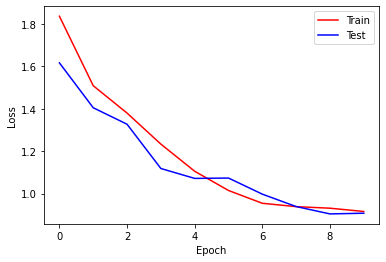

In [18]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(len(loss_epoch_train)), loss_epoch_train, 'r',label='Train') # plotting t, a separately 
plt.plot(range(len(loss_epoch_test)), loss_epoch_test, 'b',label='Test') 
plt.legend()
plt.show()

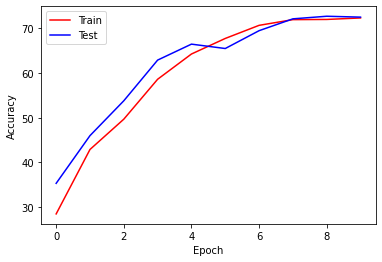

In [19]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(len(acc_train)), acc_train, 'r',label='Train') # plotting t, a separately 
plt.plot(range(len(acc_val)), acc_val, 'b',label='Test') 
plt.legend()
plt.show()

In [20]:
rnn = RNN_torch(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
optimizer=torch.optim.SGD(rnn.parameters(),lr=LR)
loss_func=nn.CrossEntropyLoss()
loss_epoch_train = []
loss_epoch_test = []
acc_train = []
acc_val = []

rnn = rnn.to(device)

for e in range(EPOCH):
    losses = []
    acc = []
    for x,y in tqdm(train_loader):
        x = torch.transpose(x,2,3)
        x = x.squeeze()
        x = x.to(device)
        y = y.to(device)
        outputs = rnn(x.unsqueeze(0))
        loss = loss_func(outputs, y)
        optimizer.zero_grad()        
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())
        y_pred = torch.argmax(outputs, dim=1)
        acc.append((y_pred == y).cpu().float().numpy())

    acc_train.append(np.sum(acc)*100/len(acc))

    loss_epoch_train.append(np.mean(losses))
    losses = []
    acc = []
    for x,y in test_loader:
        x = torch.transpose(x,2,3)
        x = x.squeeze()
        x = x.to(device)
        y = y.to(device)
        outputs = rnn(x.unsqueeze(0))
        loss = loss_func(outputs, y)
        losses.append(loss.cpu().detach().numpy())
        y_pred = torch.argmax(outputs, dim=1)
        acc.append((y_pred == y).cpu().float().numpy())
    acc_val.append(np.sum(acc)*100/len(acc))
    loss_epoch_test.append(np.mean(losses))
    print('Epoch:',int(e),' Train loss:',loss_epoch_train[e],' Test loss:'
          ,loss_epoch_test[e],' Train accuracy:',acc_train[e],' Test accuracy:',acc_val[e])

  0%|          | 61/60000 [00:00<01:38, 606.68it/s]

Epoch: 0  Train loss: 2.307073  Test loss: 2.306117  Train accuracy: 9.843333333333334  Test accuracy: 9.79


  0%|          | 63/60000 [00:00<01:35, 625.58it/s]

Epoch: 1  Train loss: 2.3049614  Test loss: 2.304288  Train accuracy: 9.858333333333333  Test accuracy: 9.77


  0%|          | 58/60000 [00:00<01:43, 579.61it/s]

Epoch: 2  Train loss: 2.3033779  Test loss: 2.302859  Train accuracy: 9.87  Test accuracy: 9.77


  0%|          | 58/60000 [00:00<01:43, 577.88it/s]

Epoch: 3  Train loss: 2.302104  Test loss: 2.3016596  Train accuracy: 9.936666666666667  Test accuracy: 10.62


  0%|          | 57/60000 [00:00<01:45, 569.38it/s]

Epoch: 4  Train loss: 2.300996  Test loss: 2.3005645  Train accuracy: 17.953333333333333  Test accuracy: 16.66


  0%|          | 58/60000 [00:00<01:43, 578.46it/s]

Epoch: 5  Train loss: 2.299944  Test loss: 2.2994778  Train accuracy: 16.398333333333333  Test accuracy: 15.61


  0%|          | 61/60000 [00:00<01:38, 607.59it/s]

Epoch: 6  Train loss: 2.298851  Test loss: 2.2982984  Train accuracy: 15.521666666666667  Test accuracy: 15.25


  0%|          | 63/60000 [00:00<01:36, 623.63it/s]

Epoch: 7  Train loss: 2.2976005  Test loss: 2.2968886  Train accuracy: 15.36  Test accuracy: 15.43


  0%|          | 58/60000 [00:00<01:44, 575.88it/s]

Epoch: 8  Train loss: 2.2960246  Test loss: 2.2950304  Train accuracy: 15.741666666666667  Test accuracy: 15.95


100%|██████████| 60000/60000 [01:24<00:00, 711.83it/s]


Epoch: 9  Train loss: 2.293824  Test loss: 2.292309  Train accuracy: 16.766666666666666  Test accuracy: 17.09


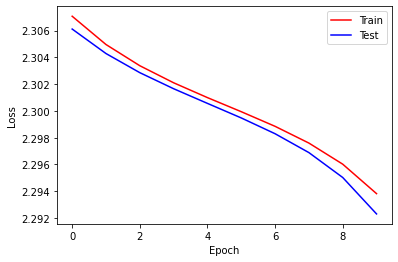

In [21]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(len(loss_epoch_train)), loss_epoch_train, 'r',label='Train') # plotting t, a separately 
plt.plot(range(len(loss_epoch_test)), loss_epoch_test, 'b',label='Test') 
plt.legend()
plt.show()

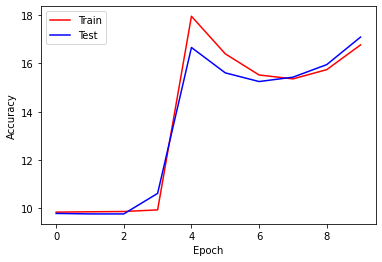

In [22]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(len(acc_train)), acc_train, 'r',label='Train') # plotting t, a separately 
plt.plot(range(len(acc_val)), acc_val, 'b',label='Test') 
plt.legend()
plt.show()